# Bayesian Change Point Analysis of Brent Oil Prices

This notebook demonstrates how to detect structural breaks in Brent oil prices using Bayesian methods (PyMC3), visualize the data, and associate change points with major events. All code and explanations are provided for reproducibility and expert-level insight.

In [1]:
# Install required libraries (uncomment if running in a new environment)
# !pip install pandas numpy matplotlib seaborn pymc3

# List required libraries
required_libs = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'pymc3']
print('Required libraries:', required_libs)

Required libraries: ['pandas', 'numpy', 'matplotlib', 'seaborn', 'pymc3']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Set visualization style
sns.set(style='whitegrid')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [3]:
# Load Brent oil price data
brent_df = pd.read_csv('../data/BrentOilPrices.csv')
brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)
brent_df = brent_df.sort_values('Date')
brent_df.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_31940\2642387652.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_31940\2642387652.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


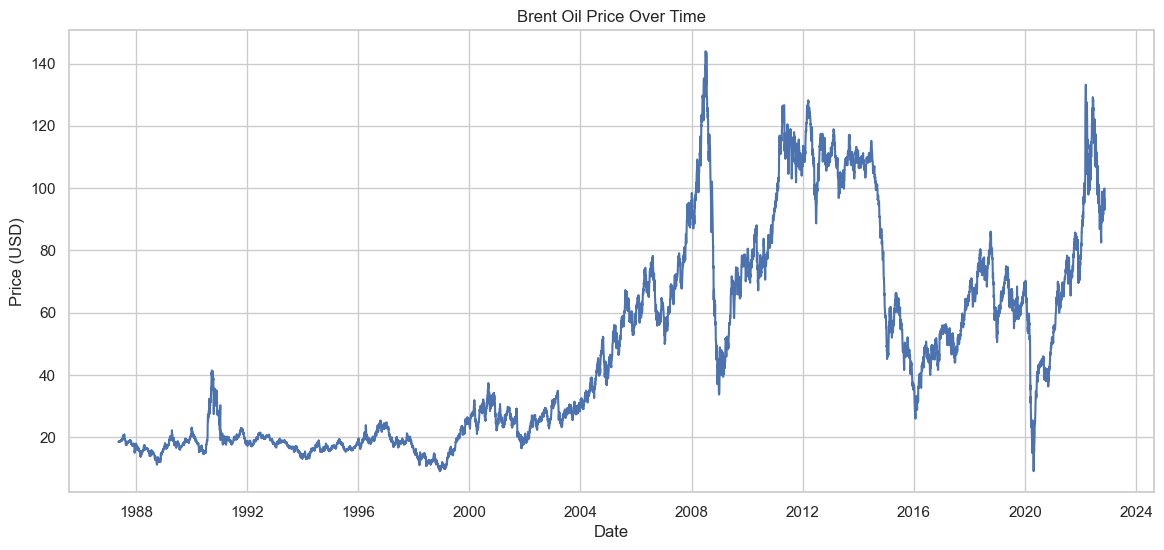

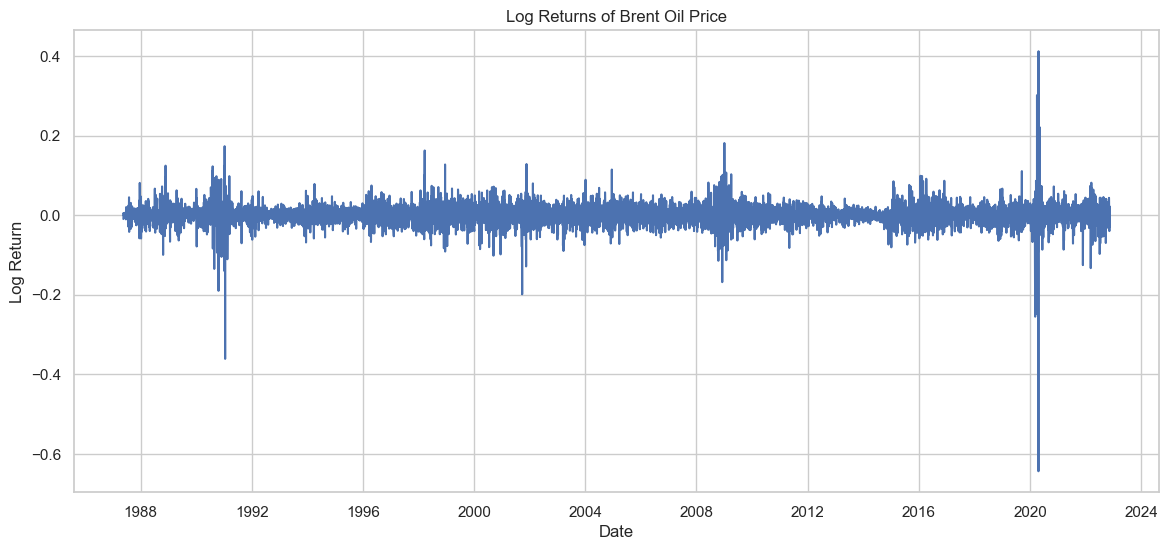

In [4]:
# Visualize Brent oil price time series
plt.figure(figsize=(14, 6))
plt.plot(brent_df['Date'], brent_df['Price'])
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Compute log returns
prices = brent_df['Price'].values
log_returns = np.log(prices[1:] / prices[:-1])
dates = brent_df['Date'].values[1:]

# Plot log returns
plt.figure(figsize=(14, 6))
plt.plot(dates, log_returns)
plt.title('Log Returns of Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Preprocess log_returns
log_returns = np.array(log_returns)
print("Length of log_returns:", len(log_returns))
print("NaNs:", np.any(np.isnan(log_returns)), "Infs:", np.any(np.isinf(log_returns)))
log_returns = log_returns[np.isfinite(log_returns)]

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=len(log_returns)//4, upper=3*len(log_returns)//4)
    mu_1 = pm.Normal('mu_1', mu=np.mean(log_returns), sigma=np.std(log_returns))
    mu_2 = pm.Normal('mu_2', mu=np.mean(log_returns), sigma=np.std(log_returns))
    sigma = pm.HalfNormal('sigma', sigma=np.std(log_returns))
    mu = pm.math.switch(tau >= np.arange(len(log_returns)), mu_1, mu_2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)
    
    # Minimal sampling, single core
    trace = pm.sample(50, tune=50, cores=1, target_accept=0.9, init='adapt_diag', random_seed=42)

# Save plot to avoid widget issue
pm.plot_trace(trace)
plt.savefig('trace_plot.png')
plt.close()
print("Trace plot saved as trace_plot.png")

# Print summary
summary = pm.summary(trace)
print(summary)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Length of log_returns: 9010
NaNs: False Infs: False


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

In [5]:
# Posterior of change point
tau_samples = trace['tau']
plt.figure(figsize=(10, 4))
sns.histplot(tau_samples, bins=50, kde=True)
plt.title('Posterior Distribution of Change Point (tau)')
plt.xlabel('Index of Change Point')
plt.ylabel('Frequency')
plt.show()

# Map change point index to date
change_date = dates[int(np.median(tau_samples))]
print(f"Most probable change point date: {change_date}")

NameError: name 'trace' is not defined

In [ ]:
# Quantify impact
mu_1_samples = trace['mu_1']
mu_2_samples = trace['mu_2']
mean_before = np.mean(mu_1_samples)
mean_after = np.mean(mu_2_samples)
print(f"Mean log return before change: {mean_before:.5f}")
print(f"Mean log return after change: {mean_after:.5f}")
impact = (mean_after - mean_before) / abs(mean_before) * 100
print(f"Percent change in mean log return: {impact:.2f}%")

# Associate with events
events = pd.read_csv('../event_data/events.csv')
events['Date'] = pd.to_datetime(events['Date'])
window = pd.Timedelta(days=30)
nearby_events = events[(events['Date'] >= change_date - window) & (events['Date'] <= change_date + window)]
print("Events near detected change point:")
display(nearby_events[['Date', 'Event', 'Description']])

## Advanced Extensions & Future Work

- Incorporate additional explanatory variables (e.g., GDP, inflation, exchange rates) for richer models.
- Explore advanced time series models: VAR for dynamic relationships, Markov-Switching for regime changes.
- Build interactive dashboards for stakeholder communication.
- Refine event association using causal inference techniques.

In [ ]:
# For faster modeling, use only the most recent 365 days of data
subset_df = brent_df.tail(365).copy()
prices = subset_df['Price'].values
log_returns = np.log(prices[1:] / prices[:-1])
dates = subset_df['Date'].values[1:]
print(f"Subset shape: {subset_df.shape}")
print(f"Log returns shape: {log_returns.shape}")